In [ ]:
!pip install dm-haiku optax

In [5]:
class ResidualStack(hk.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(ResidualStack, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._layers = []
    for i in range(num_residual_layers):
      conv3 = hk.Conv2D(
          output_channels=num_residual_hiddens,
          kernel_shape=(3, 3),
          stride=(1, 1),
          name="res3x3_%d" % i)
      conv1 = hk.Conv2D(
          output_channels=num_hiddens,
          kernel_shape=(1, 1),
          stride=(1, 1),
          name="res1x1_%d" % i)
      self._layers.append((conv3, conv1))

  def __call__(self, inputs):
    h = inputs
    for conv3, conv1 in self._layers:
      conv3_out = conv3(jax.nn.relu(h))
      conv1_out = conv1(jax.nn.relu(conv3_out))
      h += conv1_out
    return jax.nn.relu(h)  # Resnet V1 style

100%|██████████| 937/937 [00:28<00:00, 32.42it/s]


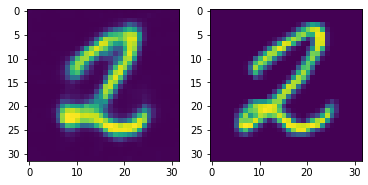

100%|██████████| 937/937 [00:26<00:00, 36.03it/s]


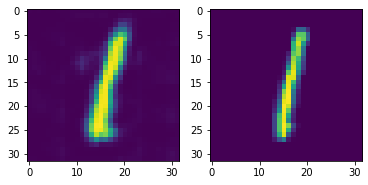

100%|██████████| 937/937 [00:25<00:00, 37.47it/s]


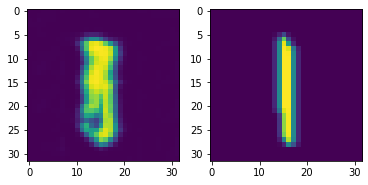

100%|██████████| 937/937 [00:25<00:00, 36.41it/s]


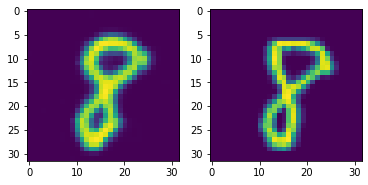

100%|██████████| 937/937 [00:26<00:00, 35.98it/s]


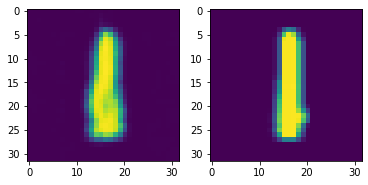

100%|██████████| 937/937 [00:25<00:00, 37.12it/s]


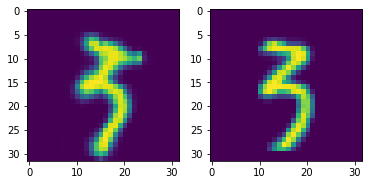

 29%|██▉       | 276/937 [00:07<00:17, 36.96it/s]

In [ ]:
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import DataLoader
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
from typing import List
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2 as cv

data_path = './'
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32))
]))
mnist_val = datasets.MNIST(data_path, train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32))
]))
train_loader = DataLoader(mnist_train, batch_size=64,
                          shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(mnist_val, batch_size=1,
                        shuffle=True, pin_memory=True, drop_last=True)

class VAE_Encoder(hk.Module):
    def __init__(self, hidden_dims: List = None, name='VAE_Encoder'):
        super().__init__(name=name)
        if hidden_dims is None:
            hidden_dims = [128, 128, 128]
        self.modules = []
        for h_dim in hidden_dims:
            self.modules.append((hk.Conv2D(output_channels=h_dim,
                                           kernel_shape=3, stride=2), hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.999)))
        self.fc = hk.Linear(64)
        self._residual_stack = ResidualStack(128,2,32)
    def __call__(self, x):
        #x = self._residual_stack(x)
        for layer_i, bn_i in self.modules:
            x = layer_i(x)
            x = bn_i(x, is_training=True)
            x = jax.nn.leaky_relu(x)
        x = self.fc(x)
        return x


class VAE_Decoder(hk.Module):
    def __init__(self, hidden_dims: List = None, name='VAE_Decoder'):
        super().__init__(name=name)
        if hidden_dims is None:
            self.hidden_dims = [128, 128, 128]
        self.modules = []
        self.conv_dim = 7
        for h_dim in self.hidden_dims:
            self.modules.append((hk.Conv2DTranspose(output_channels=h_dim,
                                                    kernel_shape=3, stride=2), hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.999)))
        self.finally_Linear = hk.Linear(1)
        self._residual_stack = ResidualStack(128,2,32)

    def __call__(self, x):
        for layer_i, bn_i in self.modules:
            x = layer_i(x)
            x = bn_i(x, is_training = True)
            x = jax.nn.leaky_relu(x)
        #x = self._residual_stack(x)
        x = self.finally_Linear(x)
        x = jax.nn.sigmoid(x)
        return x

def vae(batch, is_training):
    x = batch
    z = VAE_Encoder()(x)
    vq_output = hk.nets.VectorQuantizer(
        embedding_dim = 64,
        num_embeddings = 128,
        commitment_cost = 0.25)(z, is_training = is_training)
    z = VAE_Decoder()(vq_output['quantize'])
    return [z, x,vq_output['loss']]

def vae_loss(params: hk.Params, state, batch, is_training):
    loss_input, state = vae.apply(params, state, rng_key, batch, is_training)
    recons = loss_input[0]
    ori_image = loss_input[1][:,:,:,:1]
    loss = optax.l2_loss(recons, ori_image) + loss_input[2]
    return loss.mean()

vae = hk.transform_with_state(vae)
dummy_x = jnp.array(np.random.rand(8, 32, 32, 1))
rng_key = jax.random.PRNGKey(42)
params, state = vae.init(rng=rng_key, batch=dummy_x, is_training=True)

optimizer = optax.adamw(learning_rate=0.001)
opt_state = optimizer.init(params)

@jax.jit
def step(params, opt_state, state, batch, is_training):
    loss_value, grads = jax.value_and_grad(vae_loss)(params, state, batch, is_training)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

for epoch in range(25):
    for x, y in tqdm(train_loader):
        x = jnp.transpose(jnp.array(x), (0, 2, 3, 1))
        params, opt_state, loss_value = step(params, opt_state, state, x, is_training=True)
    [x, y] = next(iter(val_loader))
    x = jnp.transpose(jnp.array(x), (0, 2, 3, 1))
    res,state = vae.apply(params, state, rng_key, x, is_training=False)

    plt.subplot(1, 2, 1)
    plt.imshow(res[0].squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(res[1].squeeze())
    plt.show()
